In [9]:
from keras.models import Model

In [10]:
#we declare which layer is ip layer and which is op layer
model=Model(inputs=x,outputs=[output1,output2 ])

In [11]:
from keras.layers import *#imports all the layers

In [3]:
x=Input(shape=(3,))

In [12]:
hidden1=Dense(128,activation='relu')(x) #means hidden1 is getting input from x
hidden2=Dense(64,activation='relu')(hidden1)

output1=Dense(1,activation='linear')(hidden2)
output2=Dense(1,activation='sigmoid')(hidden2)


In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 dense_4 (Dense)             (None, 128)                  512       ['input_1[0][0]']             
                                                                                                  
 dense_5 (Dense)             (None, 64)                   8256      ['dense_4[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 1)                    65        ['dense_5[0][0]']             
                                                                                            

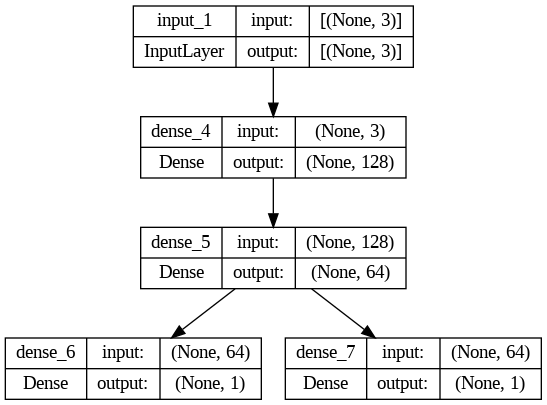

In [15]:
from keras.utils import plot_model
plot_model(model,show_shapes=True)

##utk face dataset
##from face predict->age and gender

In [16]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [18]:
!kaggle datasets download -d jangedoo/utkface-new

 97% 321M/331M [00:06<00:00, 35.4MB/s]
100% 331M/331M [00:06<00:00, 56.7MB/s]


In [20]:
import zipfile
zip=zipfile.ZipFile("/content/utkface-new.zip",'r')
zip.extractall("/content")
zip.close()

In [21]:
#import and arrange
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator


In [24]:
folder_path='/content/utkface_aligned_cropped/UTKFace'

In [25]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)


In [26]:
len(age)

23708

In [27]:
df=pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [29]:
df.shape

(23708, 3)

In [30]:
df.head()

,age,gender,img
0,18,1,18_1_2_20170104020428878.jpg.chip.jpg
1,68,0,68_0_0_20170111221718605.jpg.chip.jpg
2,36,1,36_1_1_20170113001658573.jpg.chip.jpg
3,26,0,26_0_1_20170116224835545.jpg.chip.jpg
4,20,1,20_1_4_20170103224354767.jpg.chip.jpg


In [31]:
train_df=df.sample(frac=1,random_state=0).iloc[:20000]
test_df=df.sample(frac=1,random_state=0).iloc[20000:]


In [32]:
train_df.shape

(20000, 3)

In [33]:
test_df.shape

(3708, 3)

##data aug

In [34]:
from IPython.core.display import Image
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True

)

test_datagen=ImageDataGenerator(rescale=1./255)

In [35]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                  class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [38]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [39]:
vggnet=VGG16(include_top=False,input_shape=(200,200,3))

58889256/58889256 [==============================] - 0s 0us/step


In [40]:
vggnet.trainable=False

output=vggnet.layers[-1].output

flatten=Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [42]:
 model = Model(inputs=vggnet.input,outputs=[output1,output2])

In [43]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 200, 200, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 200, 200, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

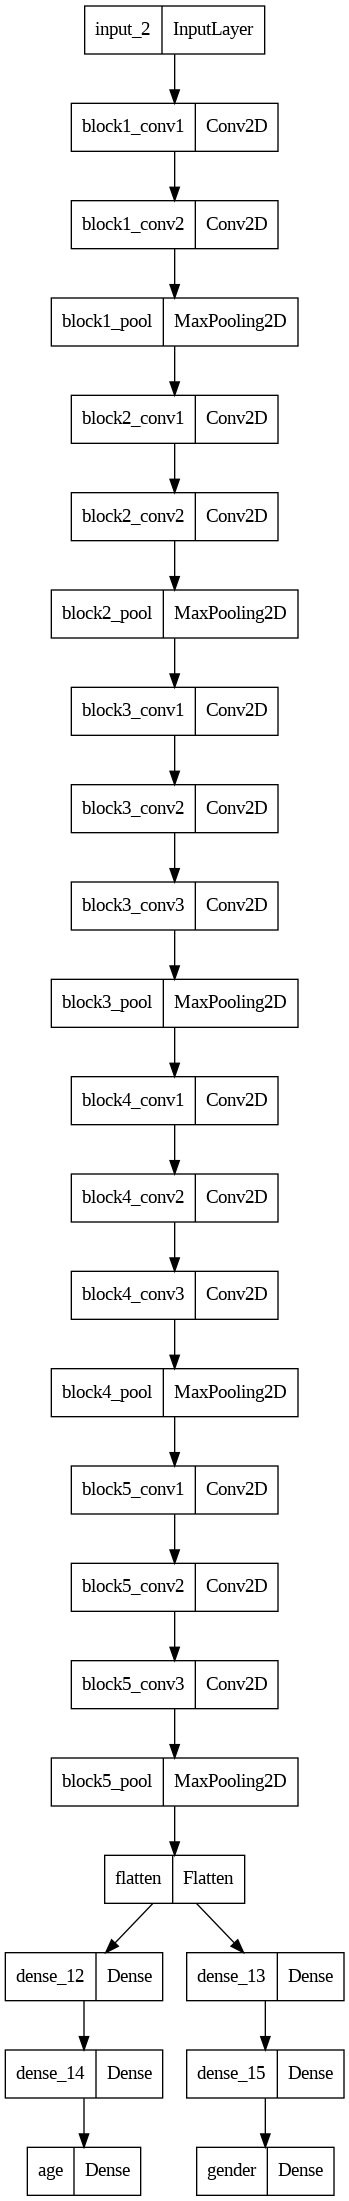

In [44]:
from keras.utils import plot_model
plot_model(model)

In [45]:
model.compile(optimizer='adam', loss={'age': 'mae', 'gender': 'binary_crossentropy'}, metrics={'age': 'mae', 'gender': 'accuracy'},loss_weights={'age':1,'gender':99})

In [ ]:
model.fit(train_generator, batch_size=32, epochs=10, validation_data=test_generator)

Epoch 1/10
  2/625 [..............................] - ETA: 2:27:05 - loss: 133.2897 - age_loss: 24.2144 - gender_loss: 1.1018 - age_mae: 24.2144 - gender_accuracy: 0.5469